In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from functools import partial

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX, NO_SELF_GRAVITY
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads


from numpyro.infer import MCMC, NUTS
import numpyro

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

plt.style.use('default')

In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)

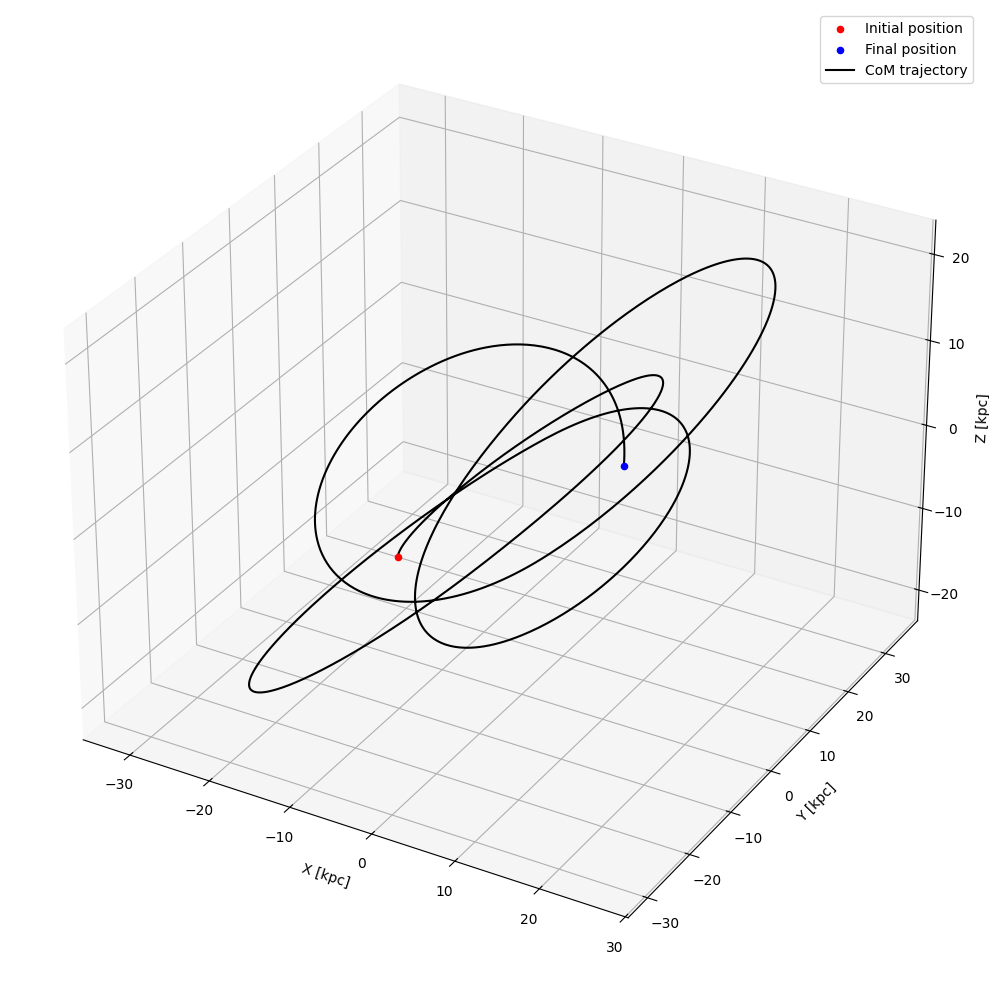

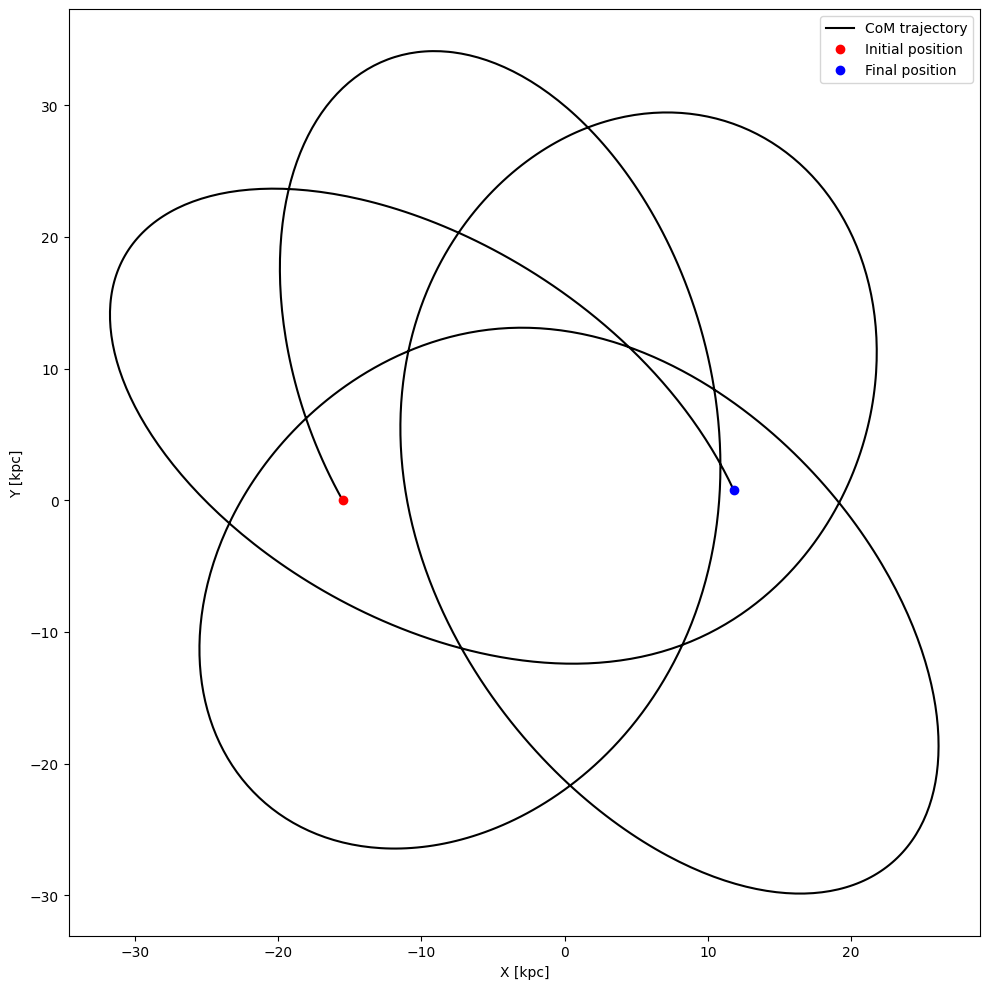

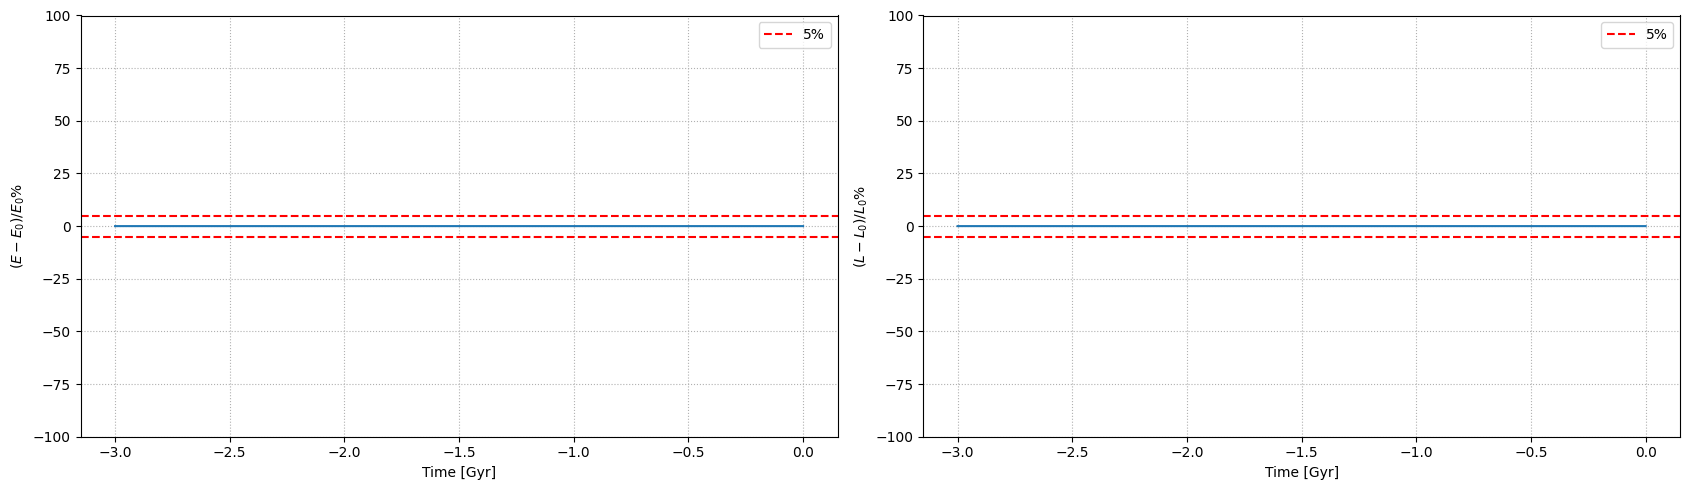

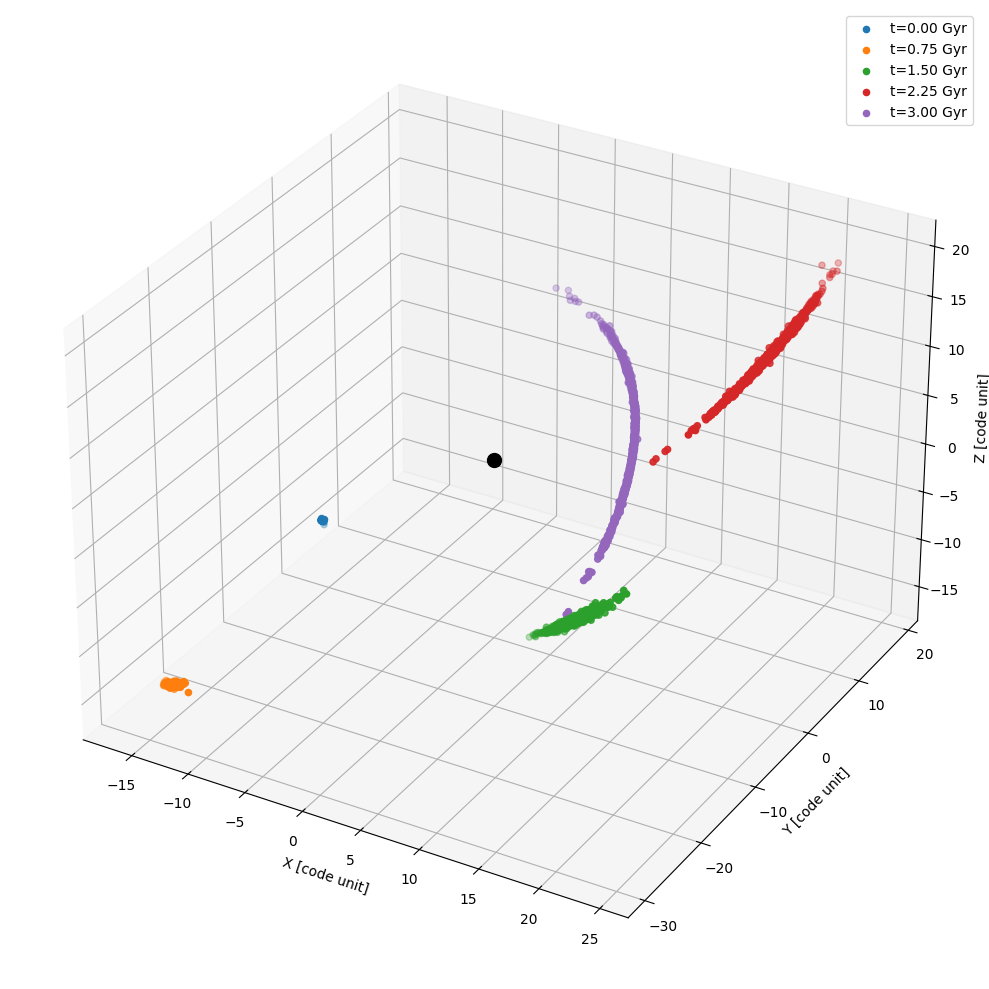

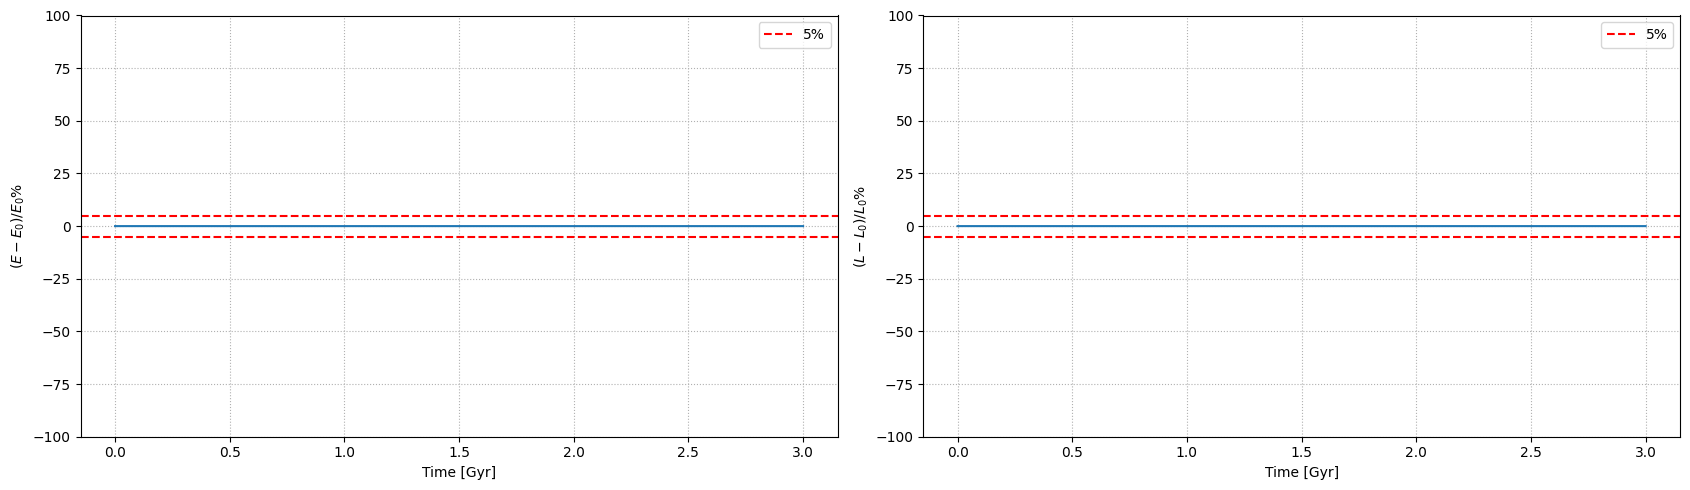

In [3]:
##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1,0, 0, 2]* code_units.code_length.to(u.kpc),c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0,0, 0, 2]* code_units.code_length.to(u.kpc), c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

##### Stream orbit plot####
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='k', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
ax.legend()


energy_angular_momentum_plot(snapshots, code_units,)


In [4]:
config_com

SimulationConfig(N_particles=1, dimensions=3, return_snapshots=True, num_snapshots=1000, fixed_timestep=False, num_timesteps=1000, softening=np.float64(1.0000000000000003e-05), integrator=2, diffrax_solver=0, acceleration_scheme=2, batch_size=10000, double_map=False, external_accelerations=(0, 2, 3), differentation_mode=1, num_checkpoints=100, progress_bar=False, gradient_horizon=0)

# MCMC

In [5]:
params

SimulationParams(G=np.float64(0.00040486519363225977), t_end=np.float64(1.0), Plummer_params=PlummerParams(a=np.float64(0.0008000000000000001), Mtot=np.float64(3.1622776601683795)), NFW_params=NFWParams(Mvir=np.float64(43683325.0), r_s=np.float64(1.6)), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=np.float64(6819390.2782346755), a=np.float64(0.30000000000000004), b=np.float64(0.028000000000000004)), PSP_params=PSPParams(M=450136.537506545, alpha=1.8, r_c=np.float64(0.19)), Logarithmic_params=LogarithmicParams(v0=220.0, q=0.9))

In [6]:
import jax.numpy as jnp
import jax
from jax import jit


import pandas as pd

from chainconsumer import Chain, ChainConsumer, Truth


from tqdm import tqdm

params_sim = params


# ----------------------------- Load observation & precompute target densities ----------------
true_GD1_observation_path = '/export/data/vgiusepp/odisseo_data/data_fix_position/true.npz'
_obs = np.load(true_GD1_observation_path)
stream_data = jnp.array(_obs['x']).reshape(1000, 6)  # will be used only to compute target densities
true_theta = jnp.array(_obs['theta'])


@jit
def run_simulation(params):

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        new_params = params_sim._replace(
                        NFW_params=params_sim.NFW_params._replace(
                            Mvir = params['M_NFW']*u.Msun.to(code_units.code_mass),
                            r_s = params['r_s']*u.kpc.to(code_units.code_length),),
                        MN_params=params_sim.MN_params._replace(
                            M = params['M_MN']*u.Msun.to(code_units.code_mass),
                            a = params['a_MN']*u.kpc.to(code_units.code_length),),
                        t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.2 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    
    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)

    return stream_coordinate_com


@jit
def stream_loglikelihood(stream_coordinate_com, ):
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]
    phi1_min, phi1_max = -120, 70
    phi2_min, phi2_max = -8, 2

    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    
    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0

    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   100000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  100000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    
    coord_indices=jnp.array([2, 3, 4, 5])

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            stream_data[:, 1], 
            phi1_forward_valid, 
            coord_forward_valid
        )

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)

    #
    sigma = jnp.array([0.5, 10., 2., 2. ]) 
 
    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    n_valid = jnp.sum(mask_stream_backward) + jnp.sum(mask_stream_forward)
    log_norm = - 0.5*n_valid * jnp.sum(jnp.log(2 * jnp.pi * sigma**2))
    log_likelihood = -0.5 * chi2 + log_norm

    return log_likelihood
    
    
@jit
def evaluate_loglikelihood(theta_1, ):

        # print(f"In the corrector: theta_1 shape: {theta_1.shape}, target shape: {target.shape}")
        output = run_simulation(theta_1)

        # return stream_likelihood(model_stream=output, obs_stream=observation, obs_errors=jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001]))
        return stream_loglikelihood(stream_coordinate_com=output, )

# True parameter values (without code_units transformation)
true_params = jnp.array([
    4.3683325e11,          # NFW Mvir (Msun)
    16.0,                  # NFW r_s (kpc)
    68_193_902_782.346756, # MN M (Msun)
    3.0,                   # MN a (kpc)
])

# Prior bounds for each parameter
prior_bounds = jnp.array([
    [4.3683325e11 * 0.25, 4.3683325e11 * 2.0],  # NFW Mvir: 1/4 to 2x true
    [16.0 * 0.25, 16.0 * 2.0],    # NFW r_s: 1/4 to 2x true (kpc)
    [68_193_902_782.346756 * 0.25, 68_193_902_782.346756 * 2.0],  # MN M: 1/4 to 2x true
    [3.0 * 0.25, 3.0 * 2.0],      # MN a: 1/4 to 2x true (kpc)
])  # Shape: (7, 2) for [min, max] bounds

def draw_from_prior(key):
    """Draw samples from uniform prior."""
    key, subkey = jax.random.split(key)
    u = jax.random.uniform(subkey, shape=(4,))
    
    # Transform uniform [0,1] to [min, max] for each parameter
    samples = prior_bounds[:, 0] + u * (prior_bounds[:, 1] - prior_bounds[:, 0])
    samples = {'M_NFW': samples[0], 'r_s': samples[1], 'M_MN': samples[2], 'a_MN': samples[3]}
    return samples

param_order = ['M_NFW', 'r_s', 'M_MN', 'a_MN']
@jit
def dict_to_array(theta_dict):
    return jnp.array([theta_dict[k] for k in param_order])

@jit
def array_to_dict(theta_array):
    return {k: theta_array[i] for i, k in enumerate(param_order)}

@jit
def evaluate_log_prior(theta):
    """Evaluate log prior density (uniform)."""
    # Check if all parameters are within bounds 
    # theta = jnp.array([theta['t_end'], theta['Mtot'], theta['a_Plummer'], theta['M_NFW'], theta['r_s'], theta['M_MN'], theta['a_MN']])
    # in_bounds = jnp.all((theta >= prior_bounds[:, 0]) & (theta <= prior_bounds[:, 1])) 
    in_bounds = jnp.all(jnp.array([
        (theta['M_NFW'] >= prior_bounds[0, 0]) & (theta['M_NFW'] <= prior_bounds[0, 1]),
        (theta['r_s'] >= prior_bounds[1, 0]) & (theta['r_s'] <= prior_bounds[1, 1]),
        (theta['M_MN'] >= prior_bounds[2, 0]) & (theta['M_MN'] <= prior_bounds[2, 1]),
        (theta['a_MN'] >= prior_bounds[3, 0]) & (theta['a_MN'] <= prior_bounds[3, 1]),
    ]))
    
    # For uniform distribution: log(density) = -log(volume)
    # Volume = product of interval widths
    log_volume = jnp.sum(jnp.log(prior_bounds[:, 1] - prior_bounds[:, 0]))
    
    # Return -inf if out of bounds, -log_volume if in bounds
    return jnp.where(in_bounds, -log_volume, -jnp.inf)
    # return -log_volume


def draw_from_proposal(key, theta, sigma2_prop):
    key, sk = jax.random.split(key)
    theta_prime = jax.random.normal(sk, shape=theta.shape) * jnp.sqrt(sigma2_prop) + theta
    return theta_prime, key

@jit
def evaluate_log_posterior_grad(theta):
    """Compute gradient of log posterior."""
    
    def log_posterior(theta):
        log_prior = evaluate_log_prior(theta)
        log_like = evaluate_loglikelihood(theta)
        return log_prior + log_like
    
    # Get both value and gradient
    log_post_val, grad = jax.value_and_grad(log_posterior)(theta)
    return log_post_val, grad

@jit
def evaluate_log_posterior(theta):
    log_prior = evaluate_log_prior(theta)
    log_like = evaluate_loglikelihood(theta_1 = theta, )
    return log_prior + log_like

@jit
def potential_fn(theta):
    return -evaluate_log_posterior(theta)

In [8]:
import jax
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.reparam import TransformReparam  # reparameterizer
import numpyro.handlers as handlers

# --- Use your prior bounds from your code ---
prior_bounds = jnp.array([
    [4.3683325e11 * 0.25, 4.3683325e11 * 2.0],  # M_NFW
    [16.0 * 0.25, 16.0 * 2.0],                   # r_s
    [68_193_902_782.346756 * 0.25, 68_193_902_782.346756 * 2.0],  # M_MN
    [3.0 * 0.25, 3.0 * 2.0],                     # a_MN
])

# convenience names / bounds
M_NFW_low, M_NFW_high = prior_bounds[0,0], prior_bounds[0,1]
r_s_low, r_s_high = prior_bounds[1,0], prior_bounds[1,1]
M_MN_low, M_MN_high = prior_bounds[2,0], prior_bounds[2,1]
a_MN_low, a_MN_high = prior_bounds[3,0], prior_bounds[3,1]


# prior bounds as in your code...
reparam_config = {
    "M_NFW": TransformReparam(),
    "r_s":   TransformReparam(),
    "M_MN":  TransformReparam(),
    "a_MN":  TransformReparam(),
}

def numpyro_stream_model():
    # only the sampling part is inside the reparam context
    with handlers.reparam(config=reparam_config):
        M_NFW = numpyro.sample("M_NFW", dist.Uniform(M_NFW_low, M_NFW_high))
        r_s   = numpyro.sample("r_s",   dist.Uniform(r_s_low,   r_s_high))
        M_MN  = numpyro.sample("M_MN",  dist.Uniform(M_MN_low,  M_MN_high))
        a_MN  = numpyro.sample("a_MN",  dist.Uniform(a_MN_low,  a_MN_high))


    # NOW: compute simulator output and attach the likelihood.
    # Important: this is outside the reparam block so TransformReparam won't see an observed site.
    params_dict = {"M_NFW": M_NFW, "r_s": r_s, "M_MN": M_MN, "a_MN": a_MN}
    stream_coord = run_simulation(params_dict)         # jitted function
    log_like = stream_loglikelihood(stream_coord)     # jitted function

    numpyro.factor("sim_loglik", log_like)            # attach simulator likelihood



In [9]:
# ---------------- NUTS / MCMC RUN ----------------
# Tuning parameters
num_chains = 1
num_warmup = 100
num_samples = 500
target_accept = 0.8  # typical NUTS tuning: 0.8..0.9

# Prepare initial positions (one per chain)
master_key = jax.random.PRNGKey(0)

# Initialize the state
# posterior_SBI = np.load('../../../../sbi_diff_sim/sbi-sim/logs/OdisseoCrossAttentionSetTransformer_small_AllParameters_Position_uniforprior_2e5_TSIT5/pictures/predicted_theta_test_set.npz')['predicted_theta'][0]
# mean = np.mean(posterior_SBI, axis=0)
# init_positions = mean[[3, 4, 5, 6]]
# init_positions[[0, 2]] = 10**init_positions[[0, 2]]
# init_positions = array_to_dict(init_positions)

master_key = jax.random.PRNGKey(42)
walker_keys = jax.random.split(master_key, num_chains)
init_positions = jax.vmap(draw_from_prior)(walker_keys)

# Build NUTS kernel with potential_fn
kernel = NUTS(potential_fn=potential_fn, target_accept_prob=target_accept, max_tree_depth=3)

mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, progress_bar=True )

# Run MCMC. For potential_fn, pass init_params as initial positions (num_chains, D).
mcmc.run(master_key, init_params=init_positions)

sample: 100%|██████████| 600/600 [2:57:51<00:00, 17.79s/it, 7 steps of size 7.14e-04. acc. prob=0.93]  


In [10]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   M_MN[0] 74576232448.00  16400.41 74576248832.00 74576248832.00 74576248832.00      1.00      1.00
  M_NFW[0] 427594678272.00  32800.82 427594711040.00 427594711040.00 427594711040.00      1.00      1.00
   a_MN[0]      1.40      0.00      1.40      1.40      1.40      8.04      1.02
    r_s[0]      6.39      0.00      6.39      6.39      6.39      9.55      1.08

Number of divergences: 0


In [11]:
import arviz as az
numpyro_data = az.from_numpyro(mcmc)
numpyro_data

Inference data with groups:
	> posterior
	> sample_stats

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


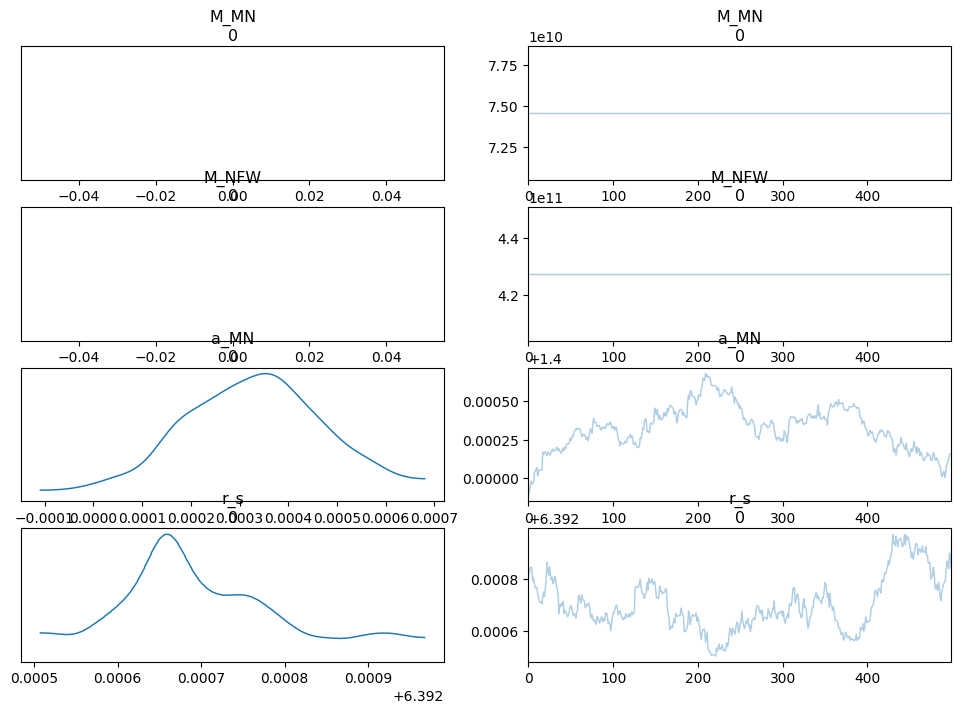

In [14]:
az.plot_trace(numpyro_data, compact=False);

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/plots/backends/matplotlib/pairplot.py:95: UserWarning: Argument reference_values does not include reference value for: M_MN 0, M_NFW 0, a_MN 0, r_s 0
  warnings.warn(


array([[<Axes: ylabel='M_NFW\n0'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='a_MN\n0'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='M_MN\n0', ylabel='r_s\n0'>,
        <Axes: xlabel='M_NFW\n0'>, <Axes: xlabel='a_MN\n0'>]],
      dtype=object)

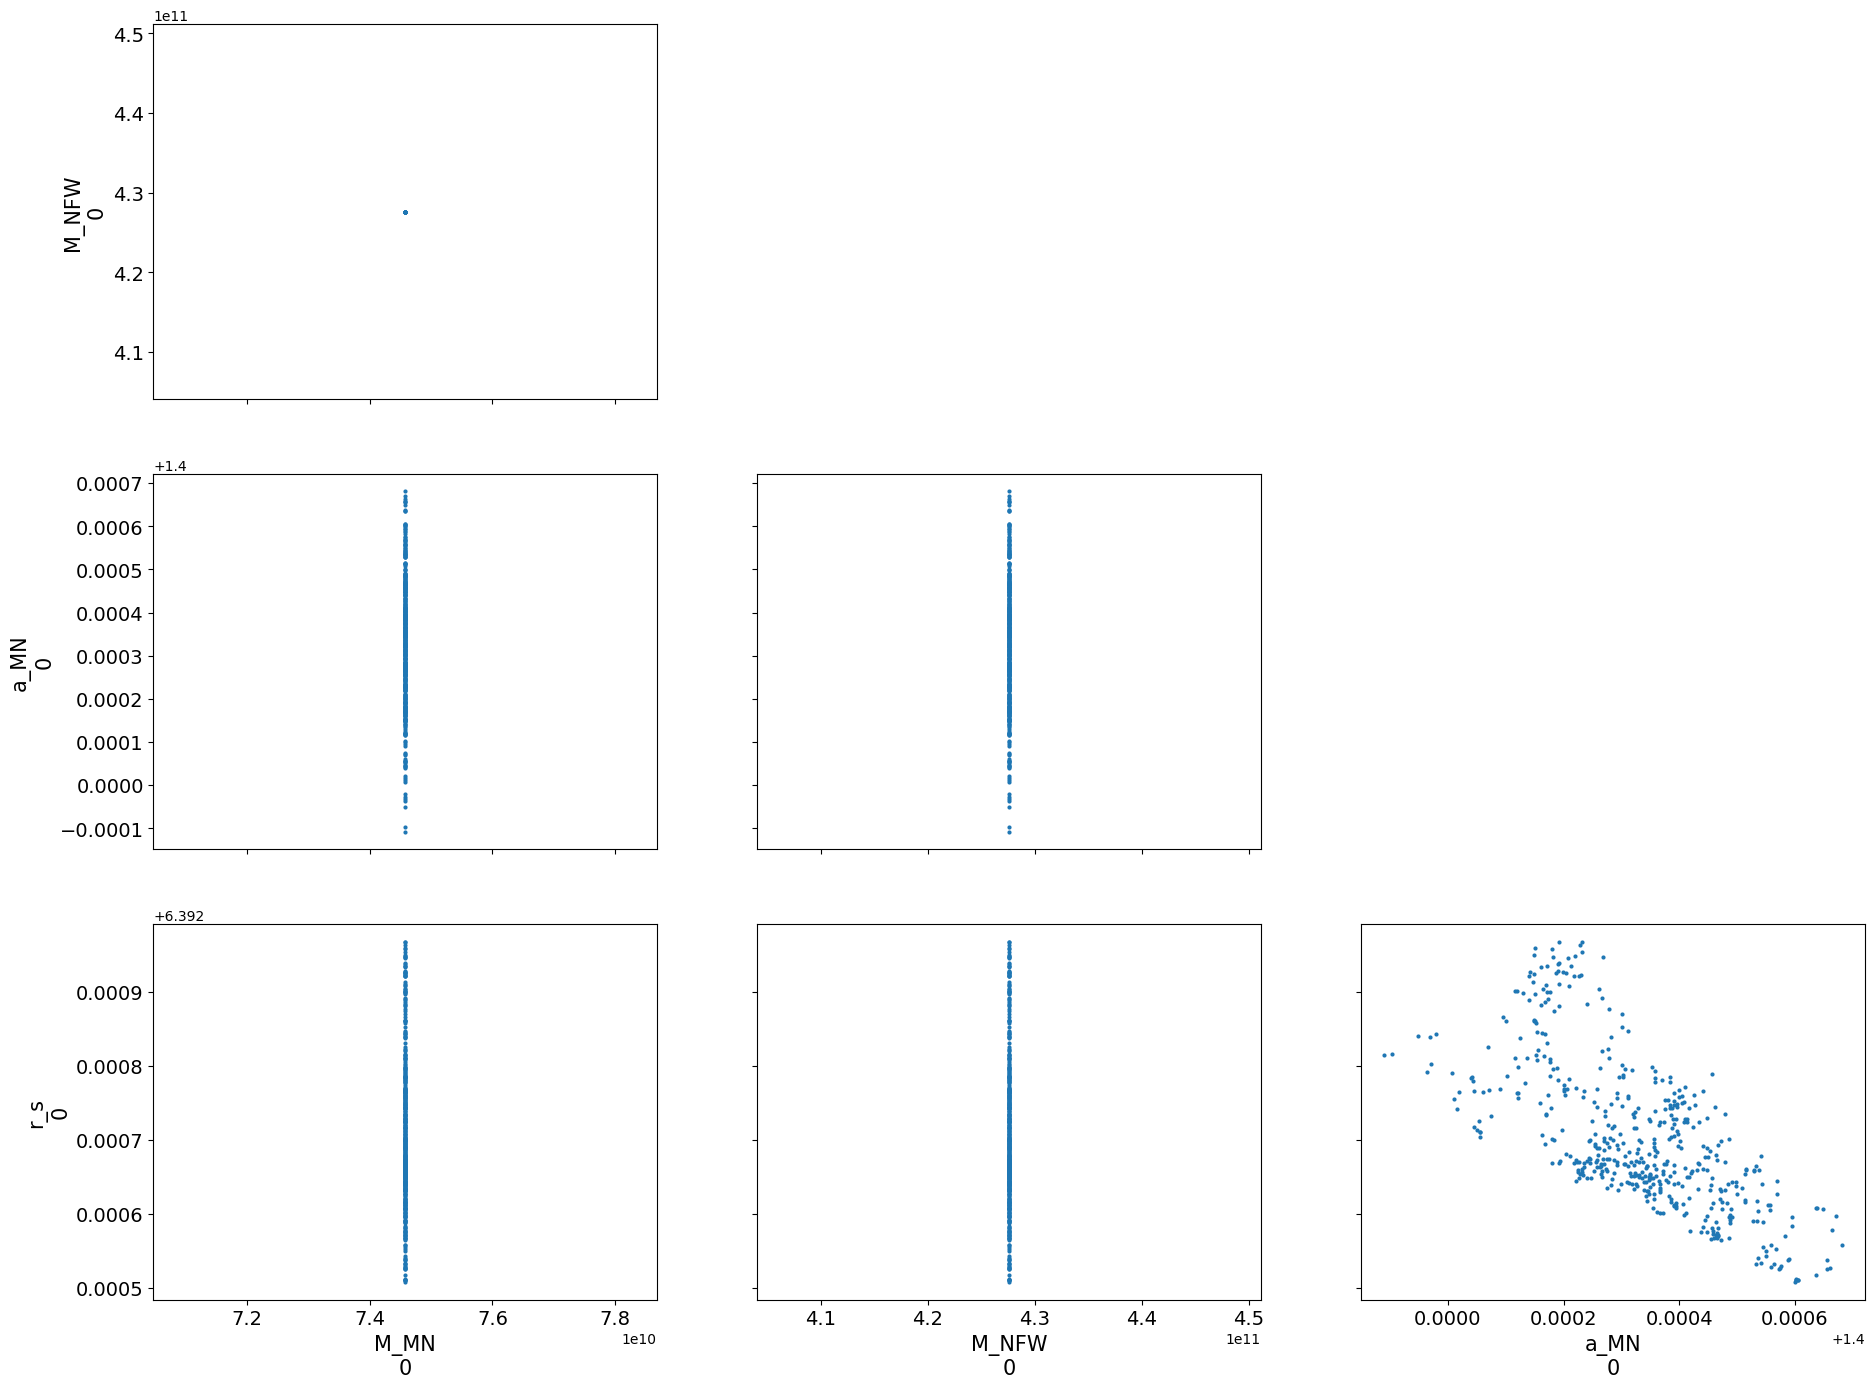

In [13]:
true_params_dict = {'M_NFW': true_params[0], 'r_s': true_params[1], 'M_MN': true_params[2], 'a_MN': true_params[3]}
az.plot_pair(numpyro_data,
             reference_values=true_params_dict,)

In [ ]:
true_params

(4,)